# Data Analysis

This notebook includes a workflow to analyze long-term average radiative fluxes from ERA5
through the lens of a model for reflected radiation from the literature. The input annual-average
data are downloaded from a Google Cloud Storage bucket, run through the model to compute one-layer
atmosphere absorption, transmission, and reflectivity (as well as potential and actual 
surface-reflected solar radiation), and averaged to arrive at a 30-year-mean of those fields. 
Finally, maps of the fields are shown and discussed.

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
from utils import check_environment

check_environment("analyze")

import contextlib
from datetime import datetime, timedelta, date
import glob
import logging
import multiprocessing
import os
from sys import platform
import time
import urllib.request
import warnings

from google.cloud import storage
import numpy as np
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import xarray as xr

### Setup

The input data for this workflow are 30 years of annual-average shortwave radiative fluxes at
the top of atmosphere and the surface, beginning in 1991 and ending in 2020.

In [2]:
start_year = 1991
end_year = 2020
data_bucket = "era5-single-level-annual"
n_jobs = -2  # number of jobs for parallelization; if 1, then serial; if negative, then (n_cpus + 1 + n_jobs) are used

# Xarray configuration
xr.set_options(keep_attrs=True)

# Multiprocessing configuration for MacOS
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396

# Logging configuration
logging.basicConfig(filename="analysis.log", filemode="w", level=logging.INFO)

# Project ID
url = "http://metadata.google.internal/computeMetadata/v1/project/project-id"
req = urllib.request.Request(url)
req.add_header("Metadata-Flavor", "Google")
project_id = urllib.request.urlopen(req).read().decode()

## Functions

In [3]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Patch joblib to report into tqdm progress bar given as argument."""

    def tqdm_print_progress(self):
        if self.n_completed_tasks > tqdm_object.n:
            n_completed = self.n_completed_tasks - tqdm_object.n
            tqdm_object.update(n=n_completed)

    original_print_progress = joblib.parallel.Parallel.print_progress
    joblib.parallel.Parallel.print_progress = tqdm_print_progress

    try:
        yield tqdm_object
    finally:
        joblib.parallel.Parallel.print_progress = original_print_progress
        tqdm_object.close()


def get_data_gcs(file_name, bucket_name, local_path=".", user_project=None):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        file_name: file_name to download from gcs.
        bucket_name: Google Cloud Storage bucket to download from.
        local_path: optional local path to download to.
        user_project: project ID for requester pays billing.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name, user_project=user_project)    
    blob = bucket.blob(file_name)
    blob.download_to_filename(filename=os.path.join(local_path, file_name))
    

def put_data_gcs(file_name, bucket_name, local_path=".", user_project=None):
    """Upload a dataset for a single date to Google Cloud Storage.
    
    Args:
        file_name: name of file to upload to gcs.
        bucket_name: Google Cloud Storage bucket to upload to.
        local_path: optional local path to upload from.
        user_project: project ID for requester pays billing.

    Returns:
        Nothing; uploads data to Google Cloud Storage.
    """
    client = storage.Client()
    bucket = client.bucket(bucket_name, user_project=user_project)    
    blob = bucket.blob(file_name)
    blob.upload_from_filename(filename=os.path.join(local_path, file_name))


def compute_radiative_properties(dataset):
    """Compute new variables based on a model following by Salamanca et al. (2012) and
    Stephens et al. (2015).
    
    Salamanca, F., Tonse, S., Menon, S., Garg, V., Singh, K., Naja, M.,
    and Fischer, M. L. (2012), Top-of-atmosphere radiative cooling with
    white roofs: experimental verification and model-based evaluation.
    Environ. Res. Lett., 7. doi: 10.1088/1748-9326/7/4/044007.
    
    Stephens, G. L., O'Brien, D., Webster, P. J., Pilewski, P., Kato, S., 
    and Li, J. (2015), The albedo of Earth. Rev. Geophys., 53, 141–163. 
    doi: 10.1002/2014RG000449.
    
    Specifically, compute system reflectivity, transmittance, and surface albedo, then
    use those properties to compute the reflectance and transmittance of a 1-layer
    atmosphere following the simple model following Salamanca et al. (2012) and 
    Stephens et al. (2015).
    
    Finally, compute the surface contribution to outgoing solar radiation and the potential
    surface contribution to the outgoing solar radiation. The latter is defined as the solar
    radiation reflected by a reference surface with albedo = 1 surrouded by the observed surface
    albedo nearby. These two properties are of particular interest to Reflective Earth in this 
    analysis.
    
    Args:
        dataset: xarray dataset containing shortwave radiative fluxes at the surface
            and top of atmosphere.
            
    Returns:
        xarray dataset with additional variables added.
    """
    # System properties
    dataset["R"] = dataset["tosr"] / dataset["tisr"]
    dataset["R"] = fill_nas(dataset["R"])
    dataset["R"].attrs["long_name"] = "Planetary albedo"
    dataset["R"].attrs["standard_name"] = "planetary_albedo"
    dataset["R"].attrs["units"] = "1"
    
    dataset["T"] = dataset["ssrd"] / dataset["tisr"]
    dataset["T"] = fill_nas(dataset["T"])
    dataset["T"].attrs["long_name"] = "Planetary transmission"
    dataset["T"].attrs["standard_name"] = "planetary_transmittance"
    dataset["T"].attrs["units"] = "1"
    
    dataset["A"] = 1 - dataset["R"]
    dataset["A"] = fill_nas(dataset["A"])
    dataset["A"].attrs["long_name"] = "Planetary absorption"
    dataset["A"].attrs["standard_name"] = "planetary_aborptance"
    dataset["A"].attrs["units"] = "1"
    
    dataset["alpha"] = dataset["ssru"] / dataset["ssrd"]
    dataset["alpha"].attrs["long_name"] = "Surface albedo"
    dataset["alpha"].attrs["standard_name"] = "surface_albedo"
    dataset["alpha"].attrs["units"] = "1"

    # Intrinsic properties
    dataset["a"] = (dataset["tisr"] * dataset["A"] - dataset["ssrd"] * (1 - dataset["alpha"])) / dataset["tisr"]
    dataset["a"] = fill_nas(dataset["a"])
    dataset["a"].attrs["long_name"] = "1-layer atmospheric absorption"
    dataset["a"].attrs["standard_name"] = "atmosphere_absorptance"
    dataset["a"].attrs["units"] = "1"
    
    dataset["r"] = dataset["R"] - (dataset["alpha"] * dataset["T"]) * ((1 - dataset["alpha"] * dataset["R"]) /
                                                                       (1 - dataset["alpha"]**2 * dataset["T"]**2))
    dataset["r"] = fill_nas(dataset["r"])
    dataset["r"].attrs["long_name"] = "1-layer atmosphere reflectivity"
    dataset["r"].attrs["standard_name"] = "atmosphere_reflectance"
    dataset["r"].attrs["units"] = "1"
    
    dataset["t"] = 1 - dataset["r"] - dataset["a"]
    dataset["t"] = fill_nas(dataset["t"])
    dataset["t"].attrs["long_name"] = "1-layer atmospheric transmission"
    dataset["t"].attrs["standard_name"] = "atmosphere_transmittance"
    dataset["t"].attrs["units"] = "1"

    # Reflective properties
    dataset["srosr"] = dataset["tisr"] * (dataset["R"] - dataset["r"])
    dataset["srosr"].attrs["long_name"] = "Surface-reflected outgoing solar radiation"
    dataset["srosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["srosr"].attrs["units"] = dataset["tisr"].attrs["units"]
    
    dataset["psrosr"] = dataset["tisr"] * (dataset["t"]**2 / (1 - (dataset["alpha"] * dataset["r"])))
    dataset["psrosr"].attrs["long_name"] = "Potential surface-reflected outgoing solar radiation"
    dataset["psrosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["psrosr"].attrs["units"] = dataset["tisr"].attrs["units"]
    
    check_data(dataset)

    return dataset


def check_data(data):
    """Check data for errors.
    
    Args:
        data: xarray Dataset with radiative properties.
        
    Raises:
        AssertionError: if any of the check conditions are false.
    """
    # Check for infinites
    assert data.psrosr.where(np.isinf(data.psrosr)).count() == 0
    assert data.srosr.where(np.isinf(data.srosr)).count() == 0
    assert data.t.where(np.isinf(data.t)).count() == 0
    assert data.r.where(np.isinf(data.r)).count() == 0
    assert data.a.where(np.isinf(data.a)).count() == 0
    # Check that t+r+a=1
    np.testing.assert_allclose((data.a + data.t + data.r).mean(dim="time").values,
                                np.ones((ds.sizes["latitude"], ds.sizes["longitude"])))


def fill_nas(data):
    """Fill in NaN for certain conditions.
    
    Args:
        data: xarray DataArray.
    
    Returns:
        xarray DataArray with zeros filled in certain conditions.
    """
    data = data.where(~np.isinf(data)).fillna(np.nan)  # fill infinite values with 0
    data = data.where(data < 1).fillna(np.nan)  # fill values greater than 1 with 1
    data = data.where(data > 0).fillna(np.nan)  # fill values less than 0 with 0
    
    return data


def cleanup_files(path, file_ext):
    """Remove files with a given file extension from a specified directory."""
    for i in glob.glob(os.path.join(path, f'*.{file_ext}')):
        os.remove(i)

## Workflow

For each year from 1991 through 2020, download annual-averaged data from a bucket in GCS,
then combine the years into a single xarray Dataset, compute the radiative properties using
the Stephens et al. model, output the resulting xarray Dataset as a NetCDF file, and upload
it to a separate GCS bucket.

In [4]:
with tqdm_joblib(tqdm(total=sum(1 for _ in range(start_year, end_year + 1)))) as pbar:
        Parallel(n_jobs=n_jobs,
                 backend="multiprocessing")(delayed(get_data_gcs)(f"{year}.nc", data_bucket, user_project=project_id)
                                            for year in range(start_year, end_year + 1))

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
ds = xr.open_mfdataset("./*.nc", parallel=True)

In [6]:
ds = compute_radiative_properties(ds)

In [7]:
ds_rom = ds.mean(dim="time")
ds_rom.attrs["institution"] = "ECMWF"
ds_rom.attrs["source"] = "ERA5"
ds_rom.attrs["title"] = "Reflective Earth optimization map inputs"
ds_rom.attrs["comment"] = "Hourly-mean ERA5 boundary solar radiation fields were averaged into a long-term average (1991-2020)"

In [8]:
ds_rom.to_netcdf("rom_analysis.nc")

In [9]:
put_data_gcs(file_name="rom_analysis.nc", bucket_name="rom-input", user_project=project_id)

## Discussion

In [10]:
ds_rom = xr.open_dataset("rom_analysis.nc")

### Radiative properties from simple model of reflected radiation

#### 1-layer atmosphere transmissivity

Transmissivity is the fraction of solar radiation transmitted by the atmosphere. The cloud-free, dry regions over global deserts and subtropical ocean gyres transmit the most radiation. Cloudy regions transmit the least.

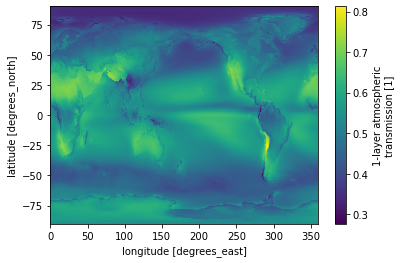

In [11]:
ds_rom.t.plot.imshow()

#### 1-layer atmosphere absorption

Absorption is the fraction of radiation absorbed by the atmosphere. It is highest over moist, dusty, and polluted regions, and lowest over dry, clear, clean regions.

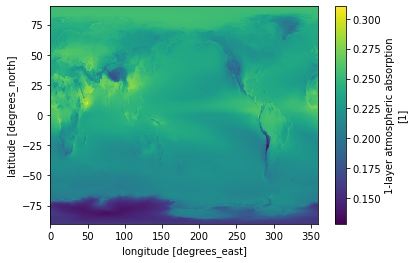

In [12]:
ds_rom.a.plot.imshow()

#### 1-layer atmosphere reflectivity

Reflectivity is the fraction of radiation reflected by the atmosphere. It is highest in cloudy regions and lowest in clear regions.

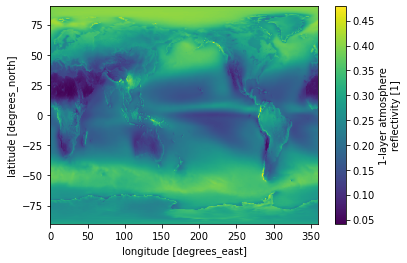

In [13]:
ds_rom.r.plot.imshow()

Constrained by conservation of energy, reflectivity, absorption, and transmissivity 
sum to equal 1. These properties are used to compute actual and potential 
surface-reflected radiation.

### Radiative properties from the input data

#### Surface albedo

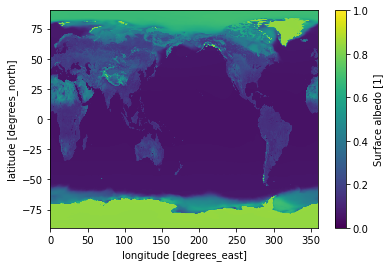

In [14]:
ds_rom.alpha.plot.imshow(vmin=0, vmax=1, cmap="viridis")

### Radiative fluxes

#### Incoming solar radiation at top of atmosphere

Nothing new here, just confirmation that the tropics receive more annual-mean solar radiation than the extratropics.

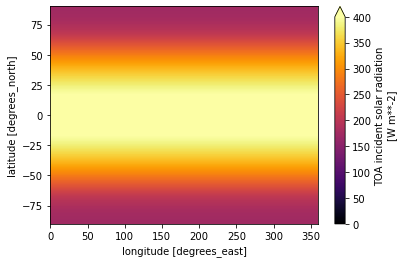

In [15]:
ds_rom.tisr.plot.imshow(vmin=0, vmax=400, cmap="inferno")

#### Atmosphere-reflected outgoing solar radiation

Multiplying 1-layer atmospheric reflectivity (*a*) by the incoming flux of solar radiation result in the flux of atmopshere-reflected outgoing solar radiation.

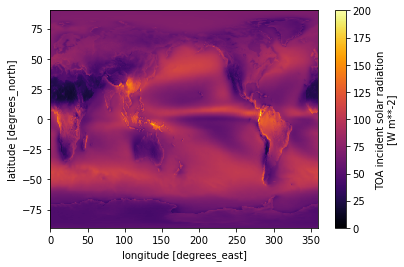

In [16]:
(ds_rom.tisr * ds_rom.r).plot.imshow(vmin=0, vmax=200, cmap="inferno")

#### Planet-received incoming solar radiation

The difference of the previous two fields results in the planet-received incoming solar radiation. This radiation is either absorbed by the atmosphere, absorbed by the surface, or reflected by the surface.

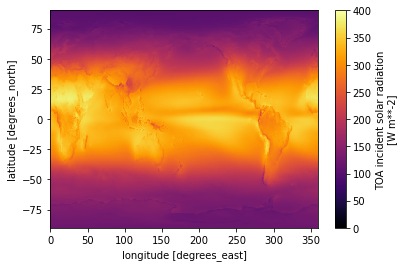

In [17]:
(ds_rom.tisr - (ds_rom.tisr * ds_rom.r)).plot.imshow(vmin=0, vmax=400, cmap="inferno")

#### Potential surface-reflected outgoing solar radiation

Global potential surface-related outgoing solar radiation assumes atmosphere retains its radiative properties (transmissivity, reflectivity, and absorption) while the surface albedo increases to 1. Over land, the largest potential is seen over western South America, and local maxima are evident over Northern and Southern Africa, Australia, Southern Asia, and southwestern North America. Over ocean, the largest potential is seen in the subtropical gyres. This suggests that oceanic albedo enhancement might be launched from the western coasts of North America, South America, Africa, and Australia.

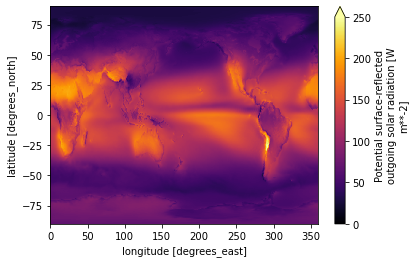

In [18]:
ds_rom.psrosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

#### Actual surface-reflected outgoing solar radiation

Global actual surface-reflected outgoing solar radiation shows the impact of the actual surface albedo. Except for parts of the Arctic and Southern Oceans that have sea ice, the ocean albedo is quite low and reflects little solar radiation. Over land, bright deserts and ice appear to be the main contributor to surface-reflected outgoing solar radiation.

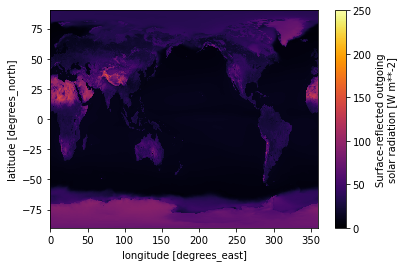

In [19]:
ds_rom.srosr.plot.imshow(vmin=0, vmax=250, cmap="inferno")

#### Potential gain in surface-reflected outgoing solar radiation

The difference of the previous two fields results in the potential gain in surface-reflected solar radiation. This emphasizes some of the features described in the first map, namely the subtropical oceans and parts of subtropics that are not already bright desert.

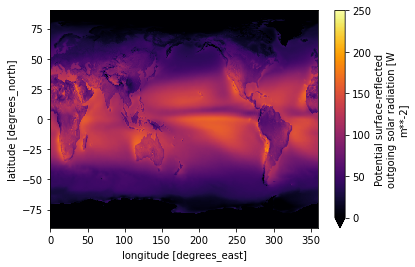

In [20]:
(ds_rom.psrosr - ds_rom.srosr).plot.imshow(vmin=0, vmax=250, cmap="inferno")

In the next notebook, `04-Deliver.ipynb`, we will create a NetCDF file input for the web-based Reflectivity Optimizaton Map tool for [reflectiveearth.org](https://reflectiveearth.org), as well as
a GeoTIFF file of the same data using the Web Mercator projection.

In [21]:
cleanup_files(path=".", file_ext="nc")